# search for protons from cosmic rays
vertex display

In [1]:
debug = 0
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/mupClassification/Figures/ExternalCosmicRejection/'
import ROOT
from larlite import *

In [2]:
from pylab import figure, title, setp, close, clf

In [3]:
from ROOT import hit,box,PandoraNuTrack,GENIEinteraction,pairVertex,AnalyseEvents

In [4]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
import sys; sys.path.insert(0, '/Users/erezcohen/larlite/UserDev/CCQEana/CCQEPackage/notebooks/'); sys.path.insert(0, '/Users/erezcohen/larlite/UserDev/mySoftware/MySoftwarePackage/mac/');
from plot_tools import *
from ccqe_notebook_tools import *
import matplotlib.colors as colors, matplotlib.patches as patches
from matplotlib.ticker import NullFormatter

In [5]:
%matplotlib inline
# %matplotlib notebook
from IPython.core.display import HTML,display
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
def get_triple_vertices( ana=None, entry=0 , debug=0 ):
    if ana is None: 
        print "ana is None! returning..."
        return
    ana.GetEntryOnlyTracks( entry )
    if debug:
        print 'grabbed entry'
    tracks = ana.GetTracks()
    if debug:
        print '%d tracks'%(int(tracks.size()))
    triplets = ana.GetTripleVertices()
    if debug:
        print '%d triplets'%(int(triplets.size()))
    return tracks,triplets

In [7]:
file=ROOT.TFile("/Users/erezcohen/Desktop/uBoone/CCQEanalysis/EventsFiles/cosmic_muon_proton_scattering.root")
tree=file.Get("EventsAnalyzer/eventsTree")
ana=AnalyseEvents(tree)

In [25]:
tracks,vertices = get_triple_vertices( entry=0 , debug=True , ana=ana)

grabbed entry
7 tracks
1 triplets


In [9]:
#---------------------------------------------------------------------------------------------
def plot_tracks(ftracks=None,plane=0,ax=None,color='',label='',do_add_numbers=False, do_add_text=False):
    for t in ftracks:
        if color=='' or label=='': color, label,_ = set_color_label_cmap(t)        
        w_start , t_start , w_end , t_end = t.GetStartWire(plane) , t.GetStartTime(plane) , t.GetEndWire(plane) , t.GetEndTime(plane)
        plt.plot([w_start,w_end],[t_start,t_end],color=color)
        if do_add_text: plt.text(w_start + 0.3*(w_end-w_start), t_start, label,color=color,fontsize=20)
#---------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------
def plot_hits(hits,plane,ax=None,cmap='hot_r',do_add_hit_trkKey=False,do_add_numbers=False,color=None
              ,label=None):
    
    hit_wire, hit_time, hit_charge , hit_number , hit_trkKey, hit_color = [] , [] , [] , [] , [], []
    hits_df=pd.DataFrame({})
    associated_hits=dict()
    for i_hit,hit in enumerate(hits):
        if hit.InPlane(plane):# and hit_in_box(hit,box=box):
            hit_wire.append(hit.GetWire())
            hit_time.append(hit.GetPeakT())
            hit_charge.append(hit.GetCharge())
    if debug>2: print 'len(hit_charge):',len(hit_charge)
    if len(hit_charge)>0:
        ax.scatter(hit_wire,hit_time,c=hit_charge if color is None else color
                   ,vmin=np.min(hit_charge), vmax=np.max(hit_charge),s=20, cmap='hot_r' , label=label)
    else:
        ax.scatter(hit_wire,hit_time,c=hit_charge if color is None else color,s=20, cmap='hot_r' , label=label)        
#---------------------------------------------------------------------------------------------

In [10]:
#---------------------------------------------------------------------------------------------    
def draw_event( cosmic_tracks=None, tracks=None , vertex=None, roi_dimesions = [100,200],  do_legend=False, legend_locs=['best','best','best'],
                leg_fontsize=20, planes=[0,1,2],tracks_leg_plane=2,figsize=(26,12),
                do_add_RdQaroundVertex=False, box_colors=['black'], box_dimesions=[(20,40)],
                do_add_mup_text=False,mu_text_xy=None,p_text_xy=None  ):
    
    fig=plt.figure(figsize=figsize)
    for plane,p_label in zip(planes,['U','V','Y']):
        ax=fig.add_subplot(1,3,plane+1)        
        # tracks
        plot_tracks(mcparticles , plane=plane , ax=ax, color='black', label='pandoraCosmic' , do_add_text=False )
        plot_tracks(tracks , plane=plane , ax=ax, color='blue', label='pandoraNu' , do_add_text=False )
        # style 
        ax.set_title(p_label+' plane',fontsize=leg_fontsize+15,y=1.02)
        if plane>0: ax.yaxis.set_major_formatter( NullFormatter() )
        ax.xaxis.set_major_formatter( ticker.FormatStrFormatter('%d') )
        xmin , xmax , xwidth = np.min(ax.get_xlim()) , np.max(ax.get_xlim()) , np.max(ax.get_xlim()) - np.min(ax.get_xlim())
        set_axes(ax,'wire','time tick' if plane==0 else '',xticks=np.linspace(xmin+0.1*xwidth,xmax-0.1*xwidth,3)
                 ,fontsize=30,do_add_grid=True)
    return fig
#---------------------------------------------------------------------------------------------

# find reconstruction efficiency for cosmic-pairs

In [43]:
#---------------------------------------------------------------------------------------------
def draw_evd_tracks_xyz(tracks=None,vertices=None,color='blue',label='pandoraNu',style='--',vertices_size=100,vertices_alpha=0.2
                        ,fontsize=20,figsize=(16,8)
                             ,xlim=(-1,250),ylim=(-120,120),zlim=(-1,1050) ):        

    fig = plt.figure(figsize=figsize)
    # x-y view
    ax = fig.add_subplot(1,3,1)
    for t in tracks:
        plt.plot([t.GetStartPos().x(),t.GetEndPos().x()],[t.GetStartPos().y(),t.GetEndPos().y()], style, color=color)
        if t.GetStartPos().x()>xlim[0] and t.GetStartPos().x()<xlim[1] and t.GetStartPos().y()>ylim[0] and t.GetStartPos().y()<ylim[1]:
            sx,sy,ex,ey=t.GetStartPos().x(),t.GetStartPos().y(),t.GetEndPos().x(),t.GetEndPos().y()
            plt.text(sx+0.12*(ex-sx),sy+0.12*(ey-sy),"track %d (pdg %d)"%(t.GetTrackID(),t.GetMCpdgCode()), color=color)

    if vertices is not None:
        for v in vertices:
            print "triple position in x-y plane:",[v.GetPosition().x()],[v.GetPosition().y()]
            plt.scatter([v.GetPosition().x()],[v.GetPosition().y()], color=color,s=vertices_size,alpha=vertices_alpha)

    set_axes(ax,x_label='x [cm]' , y_label='y [cm]',fontsize=fontsize,do_add_grid=True,xlim=xlim,ylim=ylim, do_add_legend=False)
    ax.xaxis.set_major_locator(LinearLocator(4))
    ax.xaxis.set_major_formatter( ticker.FormatStrFormatter('%d') )
    ax.yaxis.set_major_locator(LinearLocator(4))
    ax.yaxis.set_major_formatter( ticker.FormatStrFormatter('%d') )


    # z-y view
    ax = fig.add_subplot(1,3,(2,3))
    for t in tracks:
        plt.plot([t.GetStartPos().z(),t.GetEndPos().z()],[t.GetStartPos().y(),t.GetEndPos().y()], style,color=color)
        if t.GetStartPos().z()>zlim[0] and t.GetStartPos().z()<zlim[1] and t.GetStartPos().y()>ylim[0] and t.GetStartPos().y()<ylim[1]:
            sz,sy,ez,ey=t.GetStartPos().z(),t.GetStartPos().y(),t.GetEndPos().z(),t.GetEndPos().y()
            plt.text(sz+0.12*(ez-sz),sy+0.12*(ey-sy),"track %d (pdg %d)"%(t.GetTrackID(),t.GetMCpdgCode()), color=color)

    if vertices is not None:
        for v in vertices:
            print "triple position in z-y plane:",[v.GetPosition().z()],[v.GetPosition().y()]
            plt.scatter([v.GetPosition().z()],[v.GetPosition().y()], color=color,s=vertices_size,alpha=vertices_alpha)

    set_axes(ax,x_label='z [cm]',fontsize=fontsize,do_add_grid=True,xlim=zlim,ylim=ylim, do_add_legend=False)
    ax.yaxis.set_major_formatter( NullFormatter() )
    ax.xaxis.set_major_locator(LinearLocator(4))
    ax.xaxis.set_major_formatter( ticker.FormatStrFormatter('%d') )
    ax.yaxis.set_major_locator(LinearLocator(4))
#---------------------------------------------------------------------------------------------  

In [44]:
v = vertices[0]
print v.GetPosition().x(),v.GetPosition().y(),v.GetPosition().z()

153.070175171 -93.7815093994 568.265014648


triple position in x-y plane: [153.07017517089844] [-93.78150939941406]
triple position in z-y plane: [568.2650146484375] [-93.78150939941406]


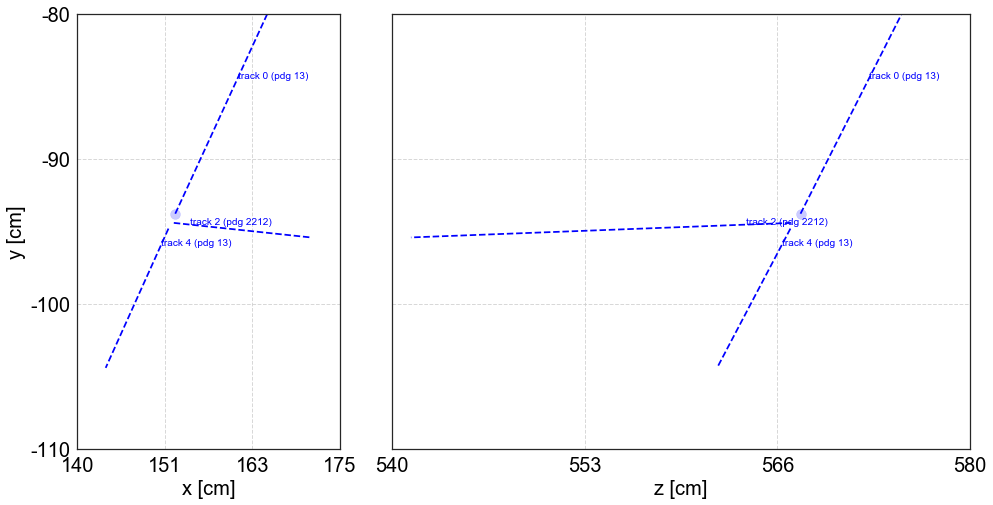

In [47]:
draw_evd_tracks_xyz(tracks=tracks,vertices=vertices,xlim=(140,175),ylim=(-110,-80),zlim=(540,580))

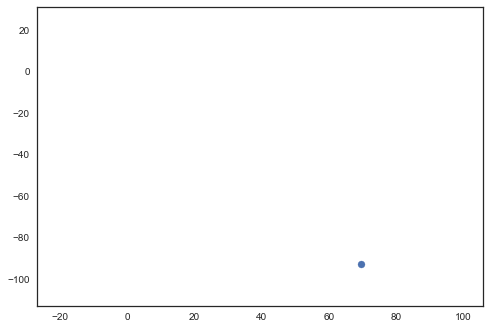

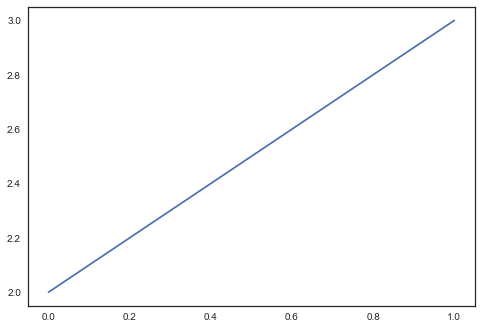

In [22]:
fig,ax=plt.subplots()
plt.plot([1892,-1231],[1800,-1903])
plt.plot([689,-58],[1800,-1333])
plt.scatter([69.5],[-93.1])
ax.set_xlim(-27,106);ax.set_ylim(-113,31)

plt.figure()
# plt.plot([1892,778],[1800,-132])
# plt.plot([689,291],[1800,900])
plt.plot([0,1],[2,3])



# prodcosmics_corsika_cmc_uboone_mcc8.4_reco2

In [10]:
#---------------------------------------------------------------------------------------------    
def draw_event( cosmic_tracks=None, tracks=None , vertex=None, roi_dimesions = [100,200],  do_legend=False, legend_locs=['best','best','best'],
                leg_fontsize=20, planes=[0,1,2],tracks_leg_plane=2,figsize=(26,12),
                do_add_RdQaroundVertex=False, box_colors=['black'], box_dimesions=[(20,40)],
                do_add_mup_text=False,mu_text_xy=None,p_text_xy=None  ):
    
    fig=plt.figure(figsize=figsize)
    for plane,p_label in zip(planes,['U','V','Y']):
        ax=fig.add_subplot(1,3,plane+1)        
        # tracks
        plot_tracks(cosmic_tracks , plane=plane , ax=ax, color='purple', label='pandoraCosmic' , do_add_text=False )
        plot_tracks(tracks , plane=plane , ax=ax, color='blue', label='pandoraNu' , do_add_text=False )
        # style 
        ax.set_title(p_label+' plane',fontsize=leg_fontsize+15,y=1.02)
        if plane>0: ax.yaxis.set_major_formatter( NullFormatter() )
        ax.xaxis.set_major_formatter( ticker.FormatStrFormatter('%d') )
        xmin , xmax , xwidth = np.min(ax.get_xlim()) , np.max(ax.get_xlim()) , np.max(ax.get_xlim()) - np.min(ax.get_xlim())
        set_axes(ax,'wire','time tick' if plane==0 else '',xticks=np.linspace(xmin+0.1*xwidth,xmax-0.1*xwidth,3)
                 ,fontsize=30,do_add_grid=True)
    return fig
#---------------------------------------------------------------------------------------------             

# draw events

In [11]:
#---------------------------------------------------------------------------------------------
def draw_evd_tracks_xyz(cosmic_tracks=None,cosmic_vertices=None,cosmic_color='purple',cosmic_label='pandoraCosmic',cosmic_style='-'
                        ,tracks=None,vertices=None,color='blue',label='pandoraNu',style='--',vertices_size=100,vertices_alpha=0.2
                        ,fontsize=20,figsize=(16,8),
                             do_add_PfromRange=False, 
                             xlim=None, ylim=None ):        

    fig = plt.figure(figsize=figsize)
    # x-y view
    ax = fig.add_subplot(1,3,1)
    for t in cosmic_tracks:
        plt.plot([t.GetStartPos().x(),t.GetEndPos().x()],[t.GetStartPos().y(),t.GetEndPos().y()], cosmic_style, color=cosmic_color)
    for t in tracks:
        plt.plot([t.GetStartPos().x(),t.GetEndPos().x()],[t.GetStartPos().y(),t.GetEndPos().y()], style, color=color)
    if cosmic_vertices is not None:
        for v in cosmic_vertices:
            plt.scatter([v.GetPosition().x()],[v.GetPosition().y()], color=cosmic_color,s=vertices_size,alpha=vertices_alpha)
    if vertices is not None:
        for v in vertices:
            plt.scatter([v.GetPosition().x()],[v.GetPosition().y()], color=color,s=vertices_size,alpha=vertices_alpha)

    set_axes(ax,x_label='x [cm]' , y_label='y [cm]',fontsize=fontsize,do_add_grid=True)
    ax.xaxis.set_major_locator(LinearLocator(4))
    ax.xaxis.set_major_formatter( ticker.FormatStrFormatter('%d') )
    ax.yaxis.set_major_locator(LinearLocator(4))
    ax.yaxis.set_major_formatter( ticker.FormatStrFormatter('%d') )


    # z-y view
    ax = fig.add_subplot(1,3,(2,3))
    for t in cosmic_tracks:
        plt.plot([t.GetStartPos().z(),t.GetEndPos().z()],[t.GetStartPos().y(),t.GetEndPos().y()], cosmic_style,color=cosmic_color)
    for t in tracks:
        plt.plot([t.GetStartPos().z(),t.GetEndPos().z()],[t.GetStartPos().y(),t.GetEndPos().y()], style,color=color)
    if cosmic_vertices is not None:
        for v in cosmic_vertices:
            plt.scatter([v.GetPosition().z()],[v.GetPosition().y()], color=cosmic_color,s=vertices_size,alpha=vertices_alpha)
    if vertices is not None:
        for v in vertices:
            plt.scatter([v.GetPosition().z()],[v.GetPosition().y()], color=color,s=vertices_size,alpha=vertices_alpha)

    set_axes(ax,x_label='z [cm]',fontsize=fontsize,do_add_grid=True)
    ax.yaxis.set_major_formatter( NullFormatter() )
    ax.xaxis.set_major_locator(LinearLocator(4))
    ax.xaxis.set_major_formatter( ticker.FormatStrFormatter('%d') )
    ax.yaxis.set_major_locator(LinearLocator(4))
#---------------------------------------------------------------------------------------------    

In [15]:
%matplotlib inline

In [14]:
cosmic_tracks,tracks,cosmic_vertices,vertices = get_pandora_tracks( entry=0 , debug=True , ana=ana)

36 cosmic-tracks,10 tracks
0 cosmic-vertices,1 vertices


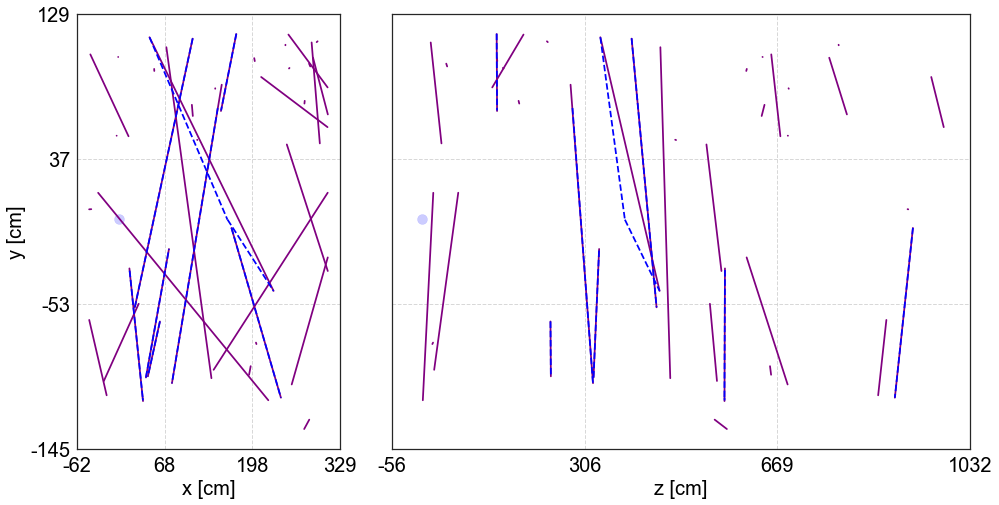

In [16]:
draw_evd_tracks_xyz(cosmic_tracks=cosmic_tracks,tracks=tracks,cosmic_vertices=cosmic_vertices,vertices=vertices)

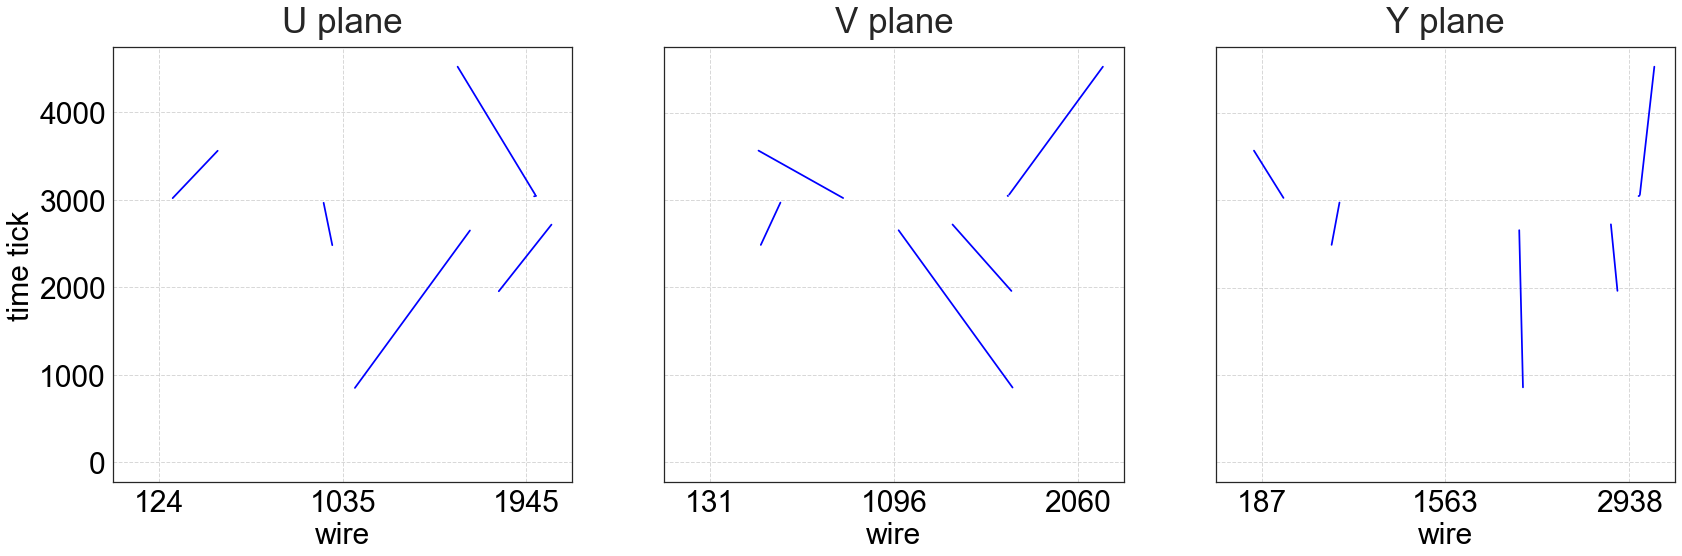

In [13]:
fig=draw_event( cosmic_tracks , tracks , planes=[0,1,2] , tracks_leg_plane=0,figsize=(28,8) )